# Background Information 

The slurp model requirs three essential inputs:  
1. Met.   
2. Canopy cover. 
3. Initial soil conditions. 


Model set up   
1. No notion of population or rowSpacing. but need to be provided via   
```Slurp.Sow(cultivar: StaticCrop, population: 1, depth: 10, rowSpacing: 150);```

2. Altering Slurp properties during runs  
In some cases users will wish to change properties of Slurp while the simulation is running. This can be done using a the set method in a manager script.   
```
object LAIResetValue = leaflai;
zone.Set("Slurp.Leaf.LAIFunction.Value()", LAIResetValue);
object HeightResetValue = CoverToday * MaximumHeight;
zone.Set("Slurp.Leaf.HeightFunction.Value()", HeightResetValue);
```
Model is driven by thermal time, so temperature and base temperature are critical?

A broken-stick threshold model was used in the thesis 

Tt is accumulated linearly at a rate of 0.7 °Cd/°C up to 15 °C and then at a rate of 1.0 until 30 

$T_b$ = 1
$T_t$ = 0.7 °Cd/°C when temperature below 15 
$T_t$ = 1 °Cd/°C when temperature is in 15 and 30 





# Prepare the cover data 

Light interception was not measured directly due to the instrement reported incorrect measurements for crops grown under droughts.

Frational light interception can be calculated from desctructive LAI   

$$R/R_0 = 1 - exp(-k\times LAI)$$

where (extinction coefficient) k was obtained by sunscan measurements. more details in the thesis and 2017 paper of Richard's

k values differ seasonally. 
k for all Iversen 12 and spring(Sep - Nov) and autumn(Feb - Apr) on both stone soils - **0.94 $\pm$ 0.014**  
k for summer (Dec - Jan) on both stone soils - **0.66 $\pm$ 0.013**

In [1]:
#load packages
import sqlite3
import re
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [3]:
# Build connection with db
con = sqlite3.connect('../../03processed-data/Richard.sqlite3')
mycur = con.cursor() 
mycur.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")
(mycur.fetchall())

[('ES',),
 ('Phenology',),
 ('SoilWater',),
 ('SowingDates',),
 ('biomass',),
 ('met_AshleyDene',),
 ('met_Iversen12',),
 ('root',)]

In [4]:
# Read data in 
biomass = pd.read_sql('Select * from biomass',  con)
met_AD = pd.read_sql('Select * from met_AshleyDene', con)
met_I12 = pd.read_sql('Select * from met_Iversen12', con)

In [5]:
LAI_Height = biomass.loc[(biomass['Seed'] == 'CS')
                         & (biomass['Harvest.No.']!='Post'), 
                         ['Experiment', 'Clock.Today', 'SowingDate', 'Rep',
                          'Plot', 'Rotation.No.', 'Harvest.No.', 'Height','LAImod']]

In [6]:
# Plot that had 'Post' measurement should be out 
LAI_Height[(LAI_Height['Harvest.No.'] == 'Post') & (LAI_Height.LAImod==0)]

,Experiment,Clock.Today,SowingDate,Rep,Plot,Rotation.No.,Harvest.No.,Height,LAImod


In [7]:
# Add the k for all 
LAI_Height['k'] = 0.94
# Replace the k for the summur crop in Ashley Dene
# LAI_Height.loc[(LAI_Height['Clock.Today'] > '2011-11-30') 
#                & (LAI_Height['Clock.Today'] < '2012-03-01') 
#                & (LAI_Height['Experiment'] == 'AshleyDene'), 'k'] = 0.66

In [8]:
LAI_Height['Date'] = pd.to_datetime(LAI_Height['Clock.Today']).dt.strftime('%Y %b')

In [9]:
LAI = LAI_Height.pivot_table(index = 'Clock.Today', 
                    columns=['Experiment', 'SowingDate'],
                    values = 'LAImod')
# Change the index to datetime tyep
LAI.index = pd.to_datetime(LAI.index)
# Rename the index name 
LAI.index.name = 'Clock.Today'
# Normalise the datetime to midnight 
LAI.index = LAI.index.normalize()
LAI

Experiment  AshleyDene                                                   \
SowingDate         SD1     SD10       SD2       SD3       SD4       SD5   
Clock.Today                                                               
2010-11-25         NaN      NaN       NaN       NaN       NaN       NaN   
2010-12-01         NaN      NaN       NaN       NaN       NaN       NaN   
2010-12-07         NaN      NaN       NaN       NaN       NaN       NaN   
2010-12-14         NaN      NaN       NaN       NaN       NaN       NaN   
2010-12-21         NaN      NaN       NaN       NaN       NaN       NaN   
...                ...      ...       ...       ...       ...       ...   
2012-06-05         NaN      NaN       NaN       NaN       NaN       NaN   
2012-06-11    0.449210      NaN  0.486274  0.497368  0.380924  0.371228   
2012-06-13         NaN  0.50823       NaN       NaN       NaN       NaN   
2012-06-23         NaN      NaN       NaN       NaN       NaN       NaN   
2012-07-11    0.424045      NaN  0.345561  0.348150  0.305000  0.308374   

Experiment                                          Iversen12           \
SowingDate        SD6       SD7       SD8       SD9       SD1     SD10   
Clock.Today                                                              
2010-11-25        NaN       NaN       NaN       NaN  0.992387      NaN   
2010-12-01        NaN       NaN       NaN       NaN  2.569125      NaN   
2010-12-07        NaN       NaN       NaN       NaN  3.718000      NaN   
2010-12-14        NaN       NaN       NaN       NaN  4.278625      NaN   
2010-12-21        NaN       NaN       NaN       NaN  4.496375      NaN   
...               ...       ...       ...       ...       ...      ...   
2012-06-05        NaN       NaN       NaN       NaN  0.398626      NaN   
2012-06-11        NaN       NaN       NaN       NaN       NaN      NaN   
2012-06-13   0.746818  0.549537  0.289766  0.395148       NaN  1.52511   
2012-06-23        NaN       NaN       NaN       NaN  0.609432      NaN   
2012-07-11        NaN       NaN       NaN       NaN  0.445263      NaN   

Experiment                                                               \
SowingDate        SD2       SD3       SD4       SD5       SD6       SD7   
Clock.Today                                                               
2010-11-25        NaN       NaN       NaN       NaN       NaN       NaN   
2010-12-01        NaN       NaN       NaN       NaN       NaN       NaN   
2010-12-07   0.321750       NaN       NaN       NaN       NaN       NaN   
2010-12-14   1.158625       NaN       NaN       NaN       NaN       NaN   
2010-12-21   1.501500       NaN       NaN       NaN       NaN       NaN   
...               ...       ...       ...       ...       ...       ...   
2012-06-05   0.356604  0.327119  0.259823  0.216369       NaN       NaN   
2012-06-11        NaN       NaN       NaN       NaN       NaN       NaN   
2012-06-13        NaN       NaN       NaN       NaN  2.757937  0.731616   
2012-06-23   0.519805  0.570002  0.438354  0.315564       NaN       NaN   
2012-07-11   0.330427  0.432394  0.434856  0.329084       NaN       NaN   

Experiment                       
SowingDate        SD8       SD9  
Clock.Today                      
2010-11-25        NaN       NaN  
2010-12-01        NaN       NaN  
2010-12-07        NaN       NaN  
2010-12-14        NaN       NaN  
2010-12-21        NaN       NaN  
...               ...       ...  
2012-06-05        NaN       NaN  
2012-06-11        NaN       NaN  
2012-06-13   2.326246  2.137679  
2012-06-23        NaN       NaN  
2012-07-11        NaN       NaN  

[176 rows x 20 columns]

# Met data to calculate thermal time 

In [10]:
met_AD = met_AD.loc[:, ['year','day', 'maxt', 'mint','mean']]
met_AD['Experiment'] = 'AshleyDene'
met_I12 = met_I12.loc[(met_I12['year'] >= 2010)                       
                      & (met_I12['year'] < 2013), ['year','day', 'maxt', 'mint','mean']]
met_I12['Experiment'] = 'Iversen12'
met = pd.concat([met_AD, met_I12], ignore_index=True)

In [11]:
# Change 4 digits year to the first date of the year
met['year'] = [str(year) + '-01-01' for year in met['year']]
met['year'] = pd.to_datetime(met['year'])
# Change the day to a delta days and add back to the year 
met['Clock.Today'] = met['year'] + pd.to_timedelta(met['day'], unit='D')

In [12]:
met = met[(met['Clock.Today'] > '2010-06-01')
          &(met['Clock.Today'] < '2012-08-01')]


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


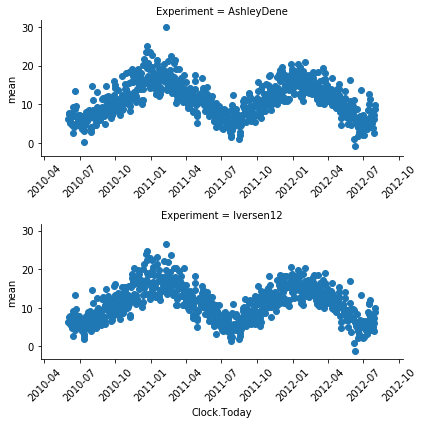

In [13]:
# Verify the filter 
# Check if any weired values. 
grid = sns.FacetGrid(met, row ='Experiment',
                     aspect=2, sharex=False)
grid.map(plt.scatter, 'Clock.Today', 'mean')
grid.set_xticklabels(rotation=45)
grid.fig.tight_layout()

In [14]:
# indexing 
met.set_index('Clock.Today', inplace = True)

In [15]:
# Try 2 sites the same time 
ThermalTimeAccum = met.loc[:, 'mean'].cumsum()
ThermalTimeAccum.index = pd.to_datetime(ThermalTimeAccum.index)

## Combine thermal time with cover data

## Interpolate daily values 

**Note**  
The for loop below complains _ValueError: fp and xp are not of the same length._  

This is probably because the LI is in a wide form 
But the thermal data is in a long form which includs two sites 


## Process sites individually   

Ashley Dene first

In [16]:
LAIAD = LAI.filter(regex = 'Ashley')
#Reindex coverdata frame to daily values
TTAccumAD = met.loc[met['Experiment'] == 'AshleyDene', 'mean'].cumsum()
TTAccumAD.index = pd.to_datetime(TTAccumAD.index)

LAIDailyAD = LAIAD.reindex(TTAccumAD.index)
LAIDailyAD.loc[:, 'AccumTT'] = TTAccumAD


In [17]:
LAIDailyAD 

Experiment  AshleyDene                                      AccumTT
SowingDate         SD1 SD10 SD2 SD3 SD4 SD5 SD6 SD7 SD8 SD9        
Clock.Today                                                        
2010-06-02         NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN     6.2
2010-06-03         NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN    13.9
2010-06-04         NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN    21.3
2010-06-05         NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN    26.4
2010-06-06         NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN    33.9
...                ...  ...  ..  ..  ..  ..  ..  ..  ..  ..     ...
2012-07-27         NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  8725.4
2012-07-28         NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  8731.5
2012-07-29         NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  8738.8
2012-07-30         NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  8747.6
2012-07-31         NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  8757.4

[791 rows x 11 columns]

In [18]:
LAIGroupedMeanAD = LAIDailyAD.groupby(axis=1, level=['Experiment', 'SowingDate']).mean()

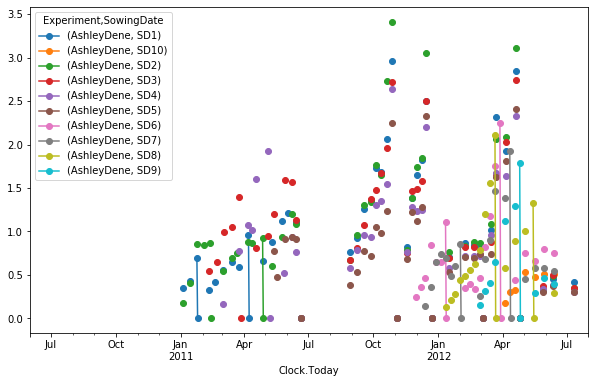

In [19]:
# Graph to check the data 
LAIGroupedMeanAD.loc[:,
                  [X for X in LAIGroupedMeanAD.columns if X != (   'AccumTT',     '')]].plot(figsize=(10, 6),style='o-')

#### Notes

MAYBE the starting point need to be forced to be 0

## Iversen12 LI interpolate

In [20]:
LAII12 = LAI.filter(regex = 'Ive')

TTAccumI12 = met.loc[met['Experiment'] == 'Iversen12', 'mean'].cumsum()
TTAccumI12.index = pd.to_datetime(TTAccumI12.index)
LAIDailyI12 = LAII12.reindex(TTAccumI12.index)  #Reindex coverdata frame to daily values
LAIDailyI12.loc[:,'AccumTT'] = TTAccumI12
# Disabled as well 
for p in LAIDailyI12.columns:
    Obs = LAIDailyI12.loc[:,p].dropna()
    LAIDailyI12.loc[:,p] = np.interp(LAIDailyI12.AccumTT,
                                   LAIDailyI12.loc[Obs.index,'AccumTT'],Obs)
LAIGroupedMeanI12 = LAIDailyI12.groupby(axis=1, level=['Experiment', 'SowingDate']).mean()

# Force the starting point to be 0

In [21]:
sowingdates = pd.read_sql('Select * from SowingDates',  con)

In [22]:
sowingdates.AD = pd.to_datetime(sowingdates.AD)
sowingdates.I12 = pd.to_datetime(sowingdates.I12)


In [23]:
# set index and rename columns 
sowingdates.set_index('SD', inplace=True)
sowingdates.columns = ['AshleyDene', 'Iversen12']

In [24]:
LAIAD = LAI.filter(regex = 'Ashley')
#Reindex coverdata frame to daily values
TTAccumAD = met.loc[(met['Experiment'] == 'AshleyDene')
                    & (met.index > '2010-10-01'), 'mean'].cumsum()
TTAccumAD.index = pd.to_datetime(TTAccumAD.index)

LAIDailyAD = LAIAD.reindex(TTAccumAD.index)
LAIDailyAD.loc[:, 'AccumTT'] = TTAccumAD

In [25]:
idx = pd.IndexSlice
LAIDailyAD.loc[LAIDailyAD.index == '2012-06-02', idx[:,'SD1']]

Experiment,AshleyDene
SowingDate,SD1
Clock.Today,
2012-06-02,NaN


In [26]:
# Force LAI to be zero
for sd in sowingdates.index:
    # Select the date for correpond sowing date
    date0 = sowingdates.at[sd, 'AshleyDene']
    # A slicer
    idx = pd.IndexSlice
    # Replace the row values with 0s
    LAIDailyAD.loc[LAIDailyAD.index <= date0, idx[:,sd]] = float(0.001)
    # Verification 
    df = LAIDailyAD.loc[LAIDailyAD.index == date0, idx[:,sd]]
#     print('\r')
#     print(date0)     
#     print(df)

#### Note   
There are still more than 4 plots for each sowing dates   
Due to seed line and harvest.no.  
The harvest.no **post** did not contribute to LAI. so should taken out.   
The Thermaltime df has duplicated the index.

In [27]:
for p in LAIDailyAD.columns:
    Obs = LAIDailyAD.loc[:,p].dropna()
    LAIDailyAD.loc[:,p] = np.interp(LAIDailyAD.AccumTT,
                                   LAIDailyAD.loc[Obs.index,'AccumTT'],Obs)

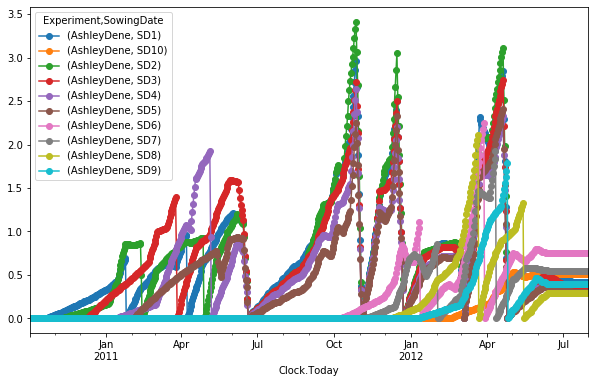

In [28]:
LAIGroupedMeanADForced = LAIDailyAD.groupby(axis=1, level=['Experiment', 'SowingDate']).mean()
# Graph to check the data 
LAIGroupedMeanADForced.loc[:,
                          [X for X in LAIGroupedMeanADForced.columns if X != (   'AccumTT',     '')]].\
plot(figsize=(10, 6),style='o-')

plt.savefig('../../05figures/StartJune_AD.png', dpi = 300, bbox_inches = 'tight')

#### Repeat for I12


In [29]:
LAII12 = LAI.filter(regex = 'Ive')

TTAccumI12 = met.loc[(met['Experiment'] == 'Iversen12')
                      & (met.index > '2010-10-01'), 'mean'].cumsum()
TTAccumI12.index = pd.to_datetime(TTAccumI12.index)
LAIDailyI12 = LAII12.reindex(TTAccumI12.index)  #Reindex coverdata frame to daily values
LAIDailyI12.loc[:,'AccumTT'] = TTAccumI12


In [30]:
for sd in sowingdates.index:
    # Select the date for correpond sowing date
    date0 = sowingdates.at[sd, 'Iversen12']
    # A slicer
    idx = pd.IndexSlice
    # Replace the row values with 0s
    LAIDailyI12.loc[LAIDailyI12.index <= date0, idx[:,sd]] = float(0.001)
    # Verification 
    df = LAIDailyI12.loc[LAIDailyI12.index == date0, idx[:,sd]]
#     print('\r')
#     print(date0)     
#     print(df)

In [31]:
# Interpolate LAI daily value by thermal time 
for p in LAIDailyI12.columns:
    Obs = LAIDailyI12.loc[:,p].dropna()
    LAIDailyI12.loc[:,p] = np.interp(LAIDailyI12.AccumTT,
                                   LAIDailyI12.loc[Obs.index,'AccumTT'],Obs)


In [32]:
LAIGroupedMeanI12Forced = LAIDailyI12.groupby(axis=1, level=['Experiment', 'SowingDate']).mean()

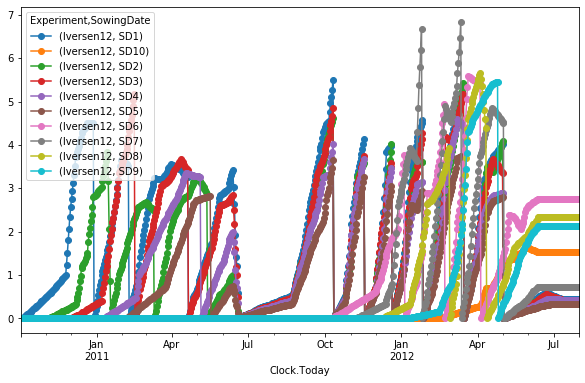

In [33]:
# Graph to check the data 
LAIGroupedMeanI12Forced.loc[:,
                           [X for X in LAIGroupedMeanI12Forced.columns \
                            if X != (   'AccumTT',     '')]].plot(figsize=(10, 6),style='o-')

In [34]:
LAIGroupedMeanI12Forced

Experiment  Iversen12                                                   \
SowingDate        SD1     SD10       SD2       SD3       SD4       SD5   
Clock.Today                                                              
2010-10-02   0.001000  0.00100  0.001000  0.001000  0.001000  0.001000   
2010-10-03   0.001000  0.00100  0.001000  0.001000  0.001000  0.001000   
2010-10-04   0.001000  0.00100  0.001000  0.001000  0.001000  0.001000   
2010-10-05   0.013963  0.00100  0.001000  0.001000  0.001000  0.001000   
2010-10-06   0.029443  0.00100  0.001000  0.001000  0.001000  0.001000   
...               ...      ...       ...       ...       ...       ...   
2012-07-27   0.445263  1.52511  0.330427  0.432394  0.434856  0.329084   
2012-07-28   0.445263  1.52511  0.330427  0.432394  0.434856  0.329084   
2012-07-29   0.445263  1.52511  0.330427  0.432394  0.434856  0.329084   
2012-07-30   0.445263  1.52511  0.330427  0.432394  0.434856  0.329084   
2012-07-31   0.445263  1.52511  0.330427  0.432394  0.434856  0.329084   

Experiment                                           AccumTT  
SowingDate        SD6       SD7       SD8       SD9           
Clock.Today                                                   
2010-10-02   0.001000  0.001000  0.001000  0.001000    10.55  
2010-10-03   0.001000  0.001000  0.001000  0.001000    20.00  
2010-10-04   0.001000  0.001000  0.001000  0.001000    29.00  
2010-10-05   0.001000  0.001000  0.001000  0.001000    37.50  
2010-10-06   0.001000  0.001000  0.001000  0.001000    47.65  
...               ...       ...       ...       ...      ...  
2012-07-27   2.757937  0.731616  2.326246  2.137679  7807.35  
2012-07-28   2.757937  0.731616  2.326246  2.137679  7813.45  
2012-07-29   2.757937  0.731616  2.326246  2.137679  7820.75  
2012-07-30   2.757937  0.731616  2.326246  2.137679  7829.55  
2012-07-31   2.757937  0.731616  2.326246  2.137679  7839.45  

[669 rows x 11 columns]

In [35]:
LAIGroupedMeanADForced

Experiment  AshleyDene                                                         \
SowingDate         SD1     SD10       SD2      SD3    SD4       SD5       SD6   
Clock.Today                                                                     
2010-10-02    0.001000  0.00100  0.001000  0.00100  0.001  0.001000  0.001000   
2010-10-03    0.001000  0.00100  0.001000  0.00100  0.001  0.001000  0.001000   
2010-10-04    0.001000  0.00100  0.001000  0.00100  0.001  0.001000  0.001000   
2010-10-05    0.001000  0.00100  0.001000  0.00100  0.001  0.001000  0.001000   
2010-10-06    0.001000  0.00100  0.001000  0.00100  0.001  0.001000  0.001000   
...                ...      ...       ...      ...    ...       ...       ...   
2012-07-27    0.424045  0.50823  0.345561  0.34815  0.305  0.308374  0.746818   
2012-07-28    0.424045  0.50823  0.345561  0.34815  0.305  0.308374  0.746818   
2012-07-29    0.424045  0.50823  0.345561  0.34815  0.305  0.308374  0.746818   
2012-07-30    0.424045  0.50823  0.345561  0.34815  0.305  0.308374  0.746818   
2012-07-31    0.424045  0.50823  0.345561  0.34815  0.305  0.308374  0.746818   

Experiment                                AccumTT  
SowingDate        SD7       SD8       SD9          
Clock.Today                                        
2010-10-02   0.001000  0.001000  0.001000    10.0  
2010-10-03   0.001000  0.001000  0.001000    19.8  
2010-10-04   0.001000  0.001000  0.001000    29.6  
2010-10-05   0.001000  0.001000  0.001000    38.7  
2010-10-06   0.001000  0.001000  0.001000    48.8  
...               ...       ...       ...     ...  
2012-07-27   0.549537  0.289766  0.395148  7799.3  
2012-07-28   0.549537  0.289766  0.395148  7805.4  
2012-07-29   0.549537  0.289766  0.395148  7812.7  
2012-07-30   0.549537  0.289766  0.395148  7821.5  
2012-07-31   0.549537  0.289766  0.395148  7831.3  

[669 rows x 11 columns]

# Output the LI DAILY

In [36]:
# Reset the index back to a column
LAIGroupedMeanADForced.columns

MultiIndex([('AshleyDene',  'SD1'),
            ('AshleyDene', 'SD10'),
            ('AshleyDene',  'SD2'),
            ('AshleyDene',  'SD3'),
            ('AshleyDene',  'SD4'),
            ('AshleyDene',  'SD5'),
            ('AshleyDene',  'SD6'),
            ('AshleyDene',  'SD7'),
            ('AshleyDene',  'SD8'),
            ('AshleyDene',  'SD9'),
            (   'AccumTT',     '')],
           names=['Experiment', 'SowingDate'])

In [37]:
CoverDFAD = LAIGroupedMeanADForced.drop('AccumTT', axis=1, level=0).stack([0,1]).reset_index()

In [38]:
CoverDFAD.columns = ['Clock.Today', 'Experiment', 'SowingDate', 'LAImod']

In [39]:
CoverDFAD[CoverDFAD['LAImod'] == 0]

,Clock.Today,Experiment,SowingDate,LAImod
1150,2011-01-25,AshleyDene,SD1,0.0
1342,2011-02-13,AshleyDene,SD2,0.0
1763,2011-03-27,AshleyDene,SD3,0.0
1880,2011-04-08,AshleyDene,SD1,0.0
2082,2011-04-28,AshleyDene,SD2,0.0
2174,2011-05-07,AshleyDene,SD4,0.0
2610,2011-06-20,AshleyDene,SD1,0.0
2612,2011-06-20,AshleyDene,SD2,0.0
2613,2011-06-20,AshleyDene,SD3,0.0
2614,2011-06-20,AshleyDene,SD4,0.0


In [40]:
# Test
CoverDFAD.loc[CoverDFAD.SowingDate == 'SD1', ['Clock.Today', 'LAImod']].\
to_csv('../../03processed-data/CoverData/CoverDataSD1.csv',index = False)

In [41]:
SDs = ['SD' + str(SD) for SD in range(1, 11)]
SDs
for i in SDs:
    CoverDFAD.loc[CoverDFAD.SowingDate == i,
                  ['Clock.Today', 'LAImod']].\
    to_csv('../../03processed-data/CoverData/LAIAshleyDene' + i + '.csv',index = False)

In [42]:
CoverDFI12 = LAIGroupedMeanI12Forced.drop('AccumTT', axis=1, level=0).stack([0,1]).reset_index()

In [43]:
CoverDFI12.columns = ['Clock.Today', 'Experiment', 'SowingDate', 'LAImod']
SDs = ['SD' + str(SD) for SD in range(1, 11)]
SDs
for i in SDs:
    CoverDFI12.loc[CoverDFI12['SowingDate'] == i, 
                   ['Clock.Today', 'LAImod']].\
    to_csv('../../03processed-data/CoverData/LAIIversen12' + i + '.csv',
                                                 index = False)

# Out put k value with light interception for Ashley Dene

In [44]:
CoverDFAD['k'] = 0.94
CoverDFAD['LI'] = 1 - np.exp( - CoverDFAD['k'] * CoverDFAD['LAImod'])
CoverDFI12['k'] = 0.94
CoverDFI12['LI'] = 1 - np.exp( - CoverDFI12['k'] * CoverDFI12['LAImod'])

In [45]:
SDs = ['SD' + str(SD) for SD in range(1, 11)]
SDs
for j in SDs:
    CoverDFAD.loc[(CoverDFAD['SowingDate'] == j),
                  ['Clock.Today', 'LI']]. \
    to_csv('../../03processed-data/CoverData/CoverAshleyDene' + j + '.csv',index = False)

In [46]:
SDs = ['SD' + str(SD) for SD in range(1, 11)]
SDs
for j in SDs:
    CoverDFI12.loc[(CoverDFI12['SowingDate'] == j),
                  ['Clock.Today', 'LI']]. \
    to_csv('../../03processed-data/CoverData/CoverIversen12' + j + '.csv',index = False)

In [47]:
LAI_Height.loc[LAI_Height['Experiment'] == 'AshleyDene', 'Height'].max()
LAI_Height.loc[LAI_Height['Experiment'] != 'AshleyDene', 'Height'].max()

59.5

#### Max height was _390 mm_ when the crop had full cover in AD
#### Max height was _595 mm_ when the crop had full cover in I12

In [48]:
LAI_Height.loc[(LAI_Height['Experiment'] == 'AshleyDene')
               &(LAI_Height['Height'] > 38), :]
LAI_Height.loc[(LAI_Height['Experiment'] != 'AshleyDene')
               &(LAI_Height['Height'] > 58), :]

,Experiment,Clock.Today,SowingDate,Rep,Plot,Rotation.No.,Harvest.No.,Height,LAImod,k,Date
1361,Iversen12,2012-01-26,SD1,2.0,32.0,4.0,4,59.5,5.828524,0.94,2012 Jan


In [65]:
df = LAI_Height.groupby(['Experiment','SowingDate', 'Clock.Today'])['LAImod'].mean()
df = df.reset_index()
sites = ['AshleyDene', 'Iversen12']
for i in sites:
    for j in SDs:
        df.loc[(df['Experiment'] == i) 
               & (df['SowingDate'] == j),
               ['Clock.Today', 'LAImod']]. \
        to_csv('../../03processed-data/CoverData/Observation' + i + j + '.csv',index = False)

In [64]:
df


,Experiment,SowingDate,Clock.Today,LAImod
0,AshleyDene,SD1,2011-01-04,0.348828
1,AshleyDene,SD1,2011-01-14,0.429502
2,AshleyDene,SD1,2011-01-24,0.697248
3,AshleyDene,SD1,2011-01-25,0.000000
4,AshleyDene,SD1,2011-02-10,0.325870
...,...,...,...,...
658,Iversen12,SD9,2012-05-09,0.650312
659,Iversen12,SD9,2012-05-16,1.004379
660,Iversen12,SD9,2012-05-23,1.469185
661,Iversen12,SD9,2012-05-30,1.722408
